In [13]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.io import loadmat
import hypyp
import mne
import numpy as np

from data_analysis.functions_connectivity import \
    plot_connectivity_matrix
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

import matplotlib.pyplot as plt
import pandas

result_dir = "/net/store/nbp/projects/hyperscanning/study_project/results/"
behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/behavioral_data"


In [2]:
phases = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", "202_early"))[0]

Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/202_early ...


<ipython-input-2-a01da109f602>:1: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/202_early) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  phases = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", "202_early"))[0]


Not setting metadata


In [3]:
subs = ["202", "203", "204", "205", "206", "207", "208", "209", "211", "212"]
conds = ["early", "late"]


data = {"early":{}, "late":{}}
for cond in conds:
    data[cond]["ispc"] = []
    data[cond]["swi"] = []
    data[cond]["alpha"] = []
    data[cond]["alpha_lin"] = []
    
    for subj in subs:

        # do the behavioral analysis and get the epochs
        df = pandas.read_csv(op.join(behav_path, str(subj) + ".csv"))
        df = calculate_alpha(df)

        # load the eeg based data
        swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]
        ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

        # remove all the trials that were removed by autoreject
        bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))["drop_list"][0]
        double_taps = loadmat(op.join(result_dir, "double_taps", str(subj) + ".mat"))["double_taps"][0]

        # remove the epochs marked as bad from autoreject
        df = df[np.logical_not(df["trial"].isin(bad_trials + 1))]

        # add the positive trial indices to remove double taps
        trial_n = np.array([i for i in range(300) if i not in bad_trials]) + 1

        # remove the epochs marked as bad from double taps
        df = df[np.logical_not(df["trial"].isin(double_taps))]
        swis = np.array([vals for trial, vals in zip(trial_n, swis) if trial not in double_taps])
        ispcs = np.array([vals for trial, vals in zip(trial_n, ispcs) if trial not in double_taps])

        trials = set(df["trial"])

        alphas = []
        alphalins = []
        for trial in trials:
            df_filt = df[df["trial"] == trial]

            if cond == "early":
                start = df_filt["ttap"].min()
                stop = start + 1.5
            else:
                stop = df_filt["ttap"].max()
                start = stop - 1.5

            df_frame = df_filt[np.logical_and(df_filt["ttap"] >= start, df_filt["ttap"] <= stop)]
            df_frame = df_frame.dropna()

            alphas.append(1 - df_frame["alpha"].mean()/ 180)
            alphalins.append(1 - df_frame["alpha_lin"].mean()/ 180)

        # add them to the lists:
        data[cond]["ispc"].append(ispcs)
        data[cond]["swi"].append(swis)
        data[cond]["alpha"].append(alphas)
        data[cond]["alpha_lin"].append(alphalins)

    data[cond]["ispc"] = np.concatenate([i for i in data[cond]["ispc"]], axis=0)
    data[cond]["swi"] = np.concatenate([i for i in data[cond]["swi"]], axis=0)
    data[cond]["alpha"] = np.concatenate([i for i in data[cond]["alpha"]], axis=0)
    data[cond]["alpha_lin"] = np.concatenate([i for i in data[cond]["alpha_lin"]], axis=0)
    
    # add to bad indices
    bad_indices = [idx for idx, val in enumerate(data[cond]["alpha"]) if np.isnan(val)]

# filter out all bad indices
all_indices = [idx for idx, val in enumerate(data[cond]["alpha"])]
good_indices = [idx for idx in all_indices if idx not in bad_indices]

for cond in conds:
    
    # select the good indices only
    data[cond]["ispc"] = data[cond]["ispc"][good_indices]
    data[cond]["swi"] = data[cond]["swi"][good_indices]
    data[cond]["alpha"] = data[cond]["alpha"][good_indices]
    data[cond]["alpha_lin"] = data[cond]["alpha_lin"][good_indices]

In [4]:
!pip install statsmodels -q

In [5]:
from scipy.stats import pearsonr, spearmanr, kstest
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan

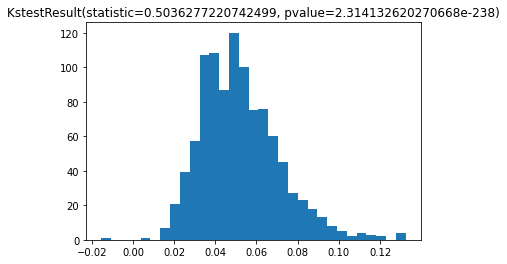

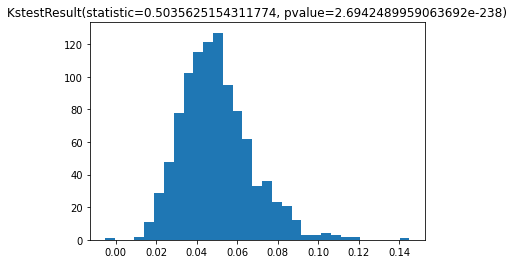

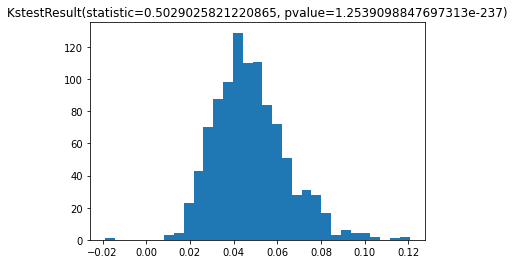

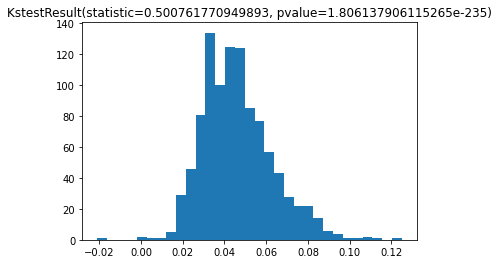

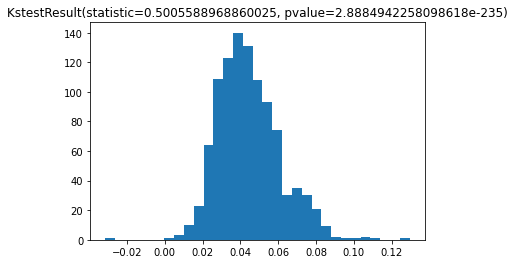

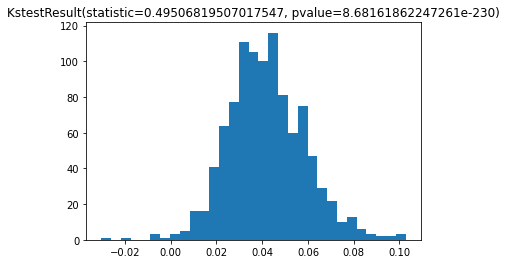

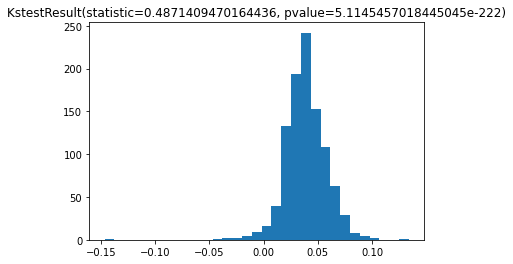

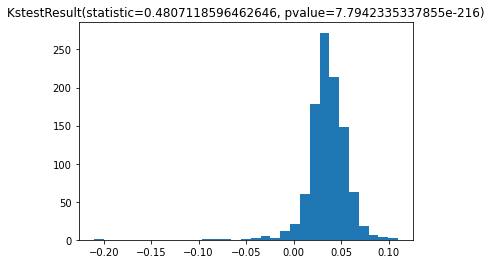

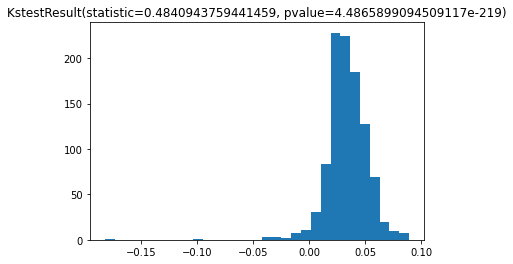

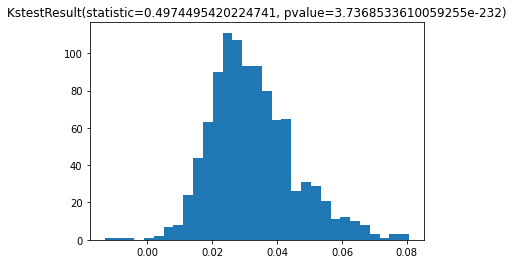

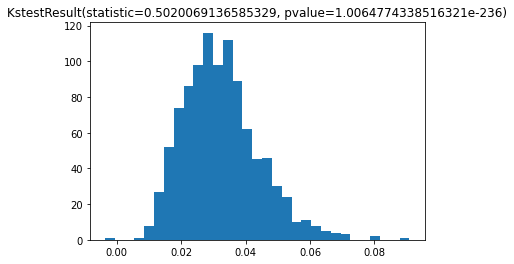

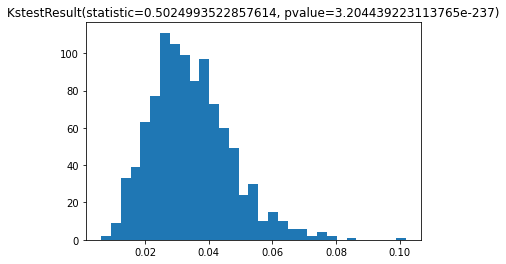

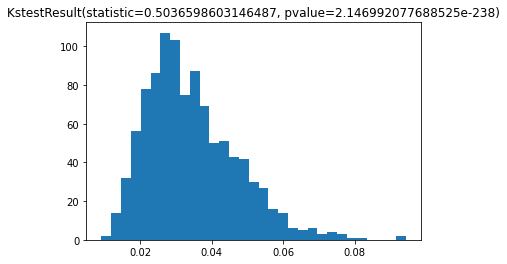

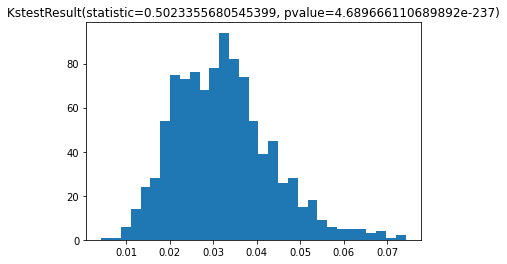

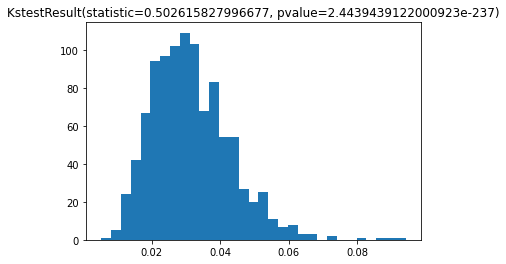

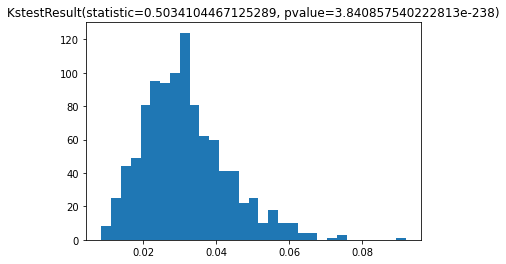

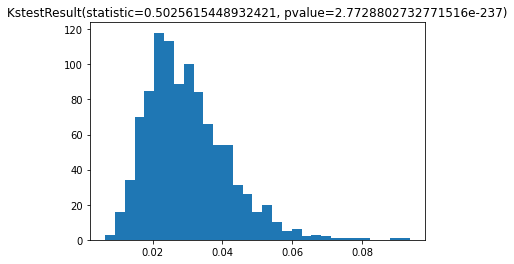

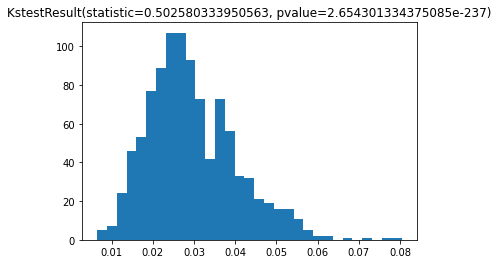

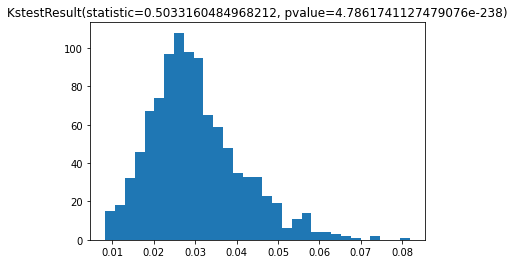

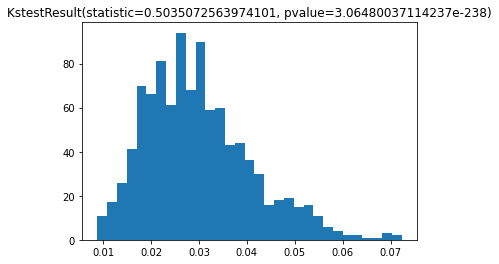

In [6]:
freqs = phases.freqs
for i, f in enumerate(freqs):
    plt.hist(data["late"]["swi"][:,i], bins=int(np.sqrt(len(data["late"]["swi"]))))
    plt.title(kstest(data["late"]["swi"][:,i], "norm"))
    plt.show()

From the above plots and the significant KS-tests for normality, we can infer that the Pearson correlation coefficient would not be the right choice for our analysis. Instead we could use Spearman's rank correlation.

H1:

In [7]:
cond="late"



x = np.mean(data[cond]["swi"], axis=-1)
y = data[cond]["alpha_lin"]

print(kstest(x, "norm"))
print(kstest(y, "norm"))

rho, sig = spearmanr(x, y)
print(rho, sig)

KstestResult(statistic=0.5051383246472869, pvalue=6.777937105311966e-240)
KstestResult(statistic=0.6860455916932403, pvalue=0.0)
-0.025302150002120615 0.42114131747205596


In [8]:

for cond in ["early", "late"]:
    data[cond]["ispc_intra"] = np.mean(data[cond]["ispc"][:, :64,:64,:], axis=(1, 2))
    data[cond]["ispc_inter"] = np.mean(data[cond]["ispc"][:, :64,64:,:], axis=(1, 2))

In [9]:
# np.mean(ispc_inter, axis=(1,2,3))1
rhos, sigs = {"late":[], "early": []}, {"late":[], "early": []}
for cond in ["late", "early"]:
    for i in range(data[cond]["swi"].shape[1]):
        x = data[cond]["swi"][:,i]
        y = data[cond]["alpha_lin"]
        rho, sig = spearmanr(x, y)

        rhos[cond].append(rho)
        sigs[cond].append(sig)

In [10]:
alpha = 190
abs(180 - abs(alpha - 180))

170

Text(0.5, 1.0, 'SWI/Alpha correlation over frequencies, for early and late condition')

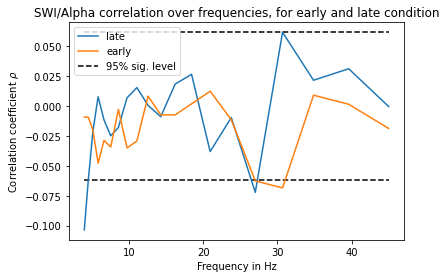

In [11]:
plt.plot(phases.freqs, rhos["late"])
plt.plot(phases.freqs, rhos["early"])
plt.hlines([0.0616, -0.0616], 4, 45, color="k", linestyles="--", label="significance level")
plt.legend(["late", "early", "95% sig. level"])
plt.ylabel(r"Correlation coefficient $\rho$")
plt.xlabel("Frequency in Hz")
plt.title("SWI/Alpha correlation over frequencies, for early and late condition")

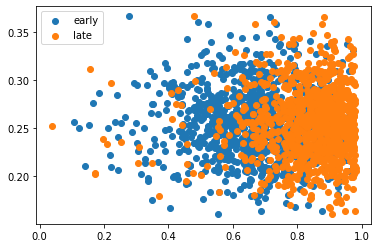

In [12]:
plt.scatter(data["early"]["alpha_lin"], data["early"]["ispc_inter"][:,16])
plt.scatter(data["late"]["alpha_lin"], data["early"]["ispc_inter"][:,16])
plt.legend(["early", "late"])